## **Mounting Google Drive**

In [34]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Installing Dependencies**

In [35]:
!pip install librosa soundfile numpy sklearn pyaudio
!pip install soundfile
!pip install resampy
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import librosa.display
import resampy

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## **Feature Extraction Function**

In [36]:
def extract_feature(file_name, mfcc, chroma, mel):
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    result = np.array([])

    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))

    if chroma:
        stft = np.abs(librosa.stft(X))
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        result = np.hstack((result, chroma))

    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)  # Corrected here
        result = np.hstack((result, mel))

    return result

## **Emotion Label Mapping**

In [38]:
emotions={
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}
observed_emotions=['neutral','calm','happy','sad','angry','fearful','disgust','surprised']

## **Loading and Splitting the Data**

In [39]:
def load_data(test_size=0.2):
  x,y=[],[]
  for file in glob.glob("/content/drive/MyDrive/ML PBL/Actor_*/*.wav"):
    file_name=os.path.basename(file)
    emotion=emotions[file_name.split("-")[2]]
    if emotion not in observed_emotions:
      continue
    feature=extract_feature(file,mfcc=True,chroma=True,mel=True)
    x.append(feature)
    y.append(emotion)
  return train_test_split(np.array(x),y,test_size=test_size,train_size=0.75,random_state=9)

## **Training the Machine Learning Model**

In [41]:
import time
import resampy
x_train,x_test,y_train,y_test=load_data(test_size=0.25)
print((x_train.shape[0],x_test.shape[0]))
print(f'Features extracted: {x_train.shape[1]}')
model=MLPClassifier(alpha=0.01,batch_size=256,epsilon=1e-08,hidden_layer_sizes=(300,),learning_rate='adaptive',max_iter=500)
model.fit(x_train,y_train)

(1080, 360)
Features extracted: 180


MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

## **Evaluating the Model**

In [42]:
y_pred=model.predict(x_test)
accuracy=accuracy_score(y_true=y_test,y_pred=y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100.0))
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))
from sklearn.metrics import confusion_matrix
matrix=confusion_matrix(y_test,y_pred)
print(matrix)

Accuracy: 44.72%
              precision    recall  f1-score   support

       angry       0.96      0.51      0.67        47
        calm       0.60      0.58      0.59        55
     disgust       0.29      0.80      0.43        46
     fearful       0.44      0.49      0.47        41
       happy       0.50      0.20      0.28        51
     neutral       0.29      0.43      0.34        28
         sad       0.53      0.37      0.43        52
   surprised       0.58      0.17      0.27        40

    accuracy                           0.45       360
   macro avg       0.52      0.44      0.43       360
weighted avg       0.54      0.45      0.44       360

[[24  1 16  0  1  2  2  1]
 [ 0 32  9  1  0  9  4  0]
 [ 0  0 37  2  3  3  0  1]
 [ 0  1  8 20  2  4  6  0]
 [ 1  2 19 12 10  3  1  3]
 [ 0  6  8  1  0 12  1  0]
 [ 0  9 11  5  2  6 19  0]
 [ 0  2 19  4  2  3  3  7]]


## **Predicting Emotion from a New Audio File**

In [44]:
def predict_emotion(file_path, model):
    features = extract_feature(file_path, mfcc=True, chroma=True, mel=True)
    features = features.reshape(1, -1)
    predicted_emotion = model.predict(features)

    return predicted_emotion[0]

new_audio_file_path = '/content/03-01-02-02-02-02-04.wav'

predicted_emotion = predict_emotion(new_audio_file_path, model)
print(f"The predicted emotion for the new audio file is: {predicted_emotion}")


The predicted emotion for the new audio file is: calm


## **Additional Enhancements**

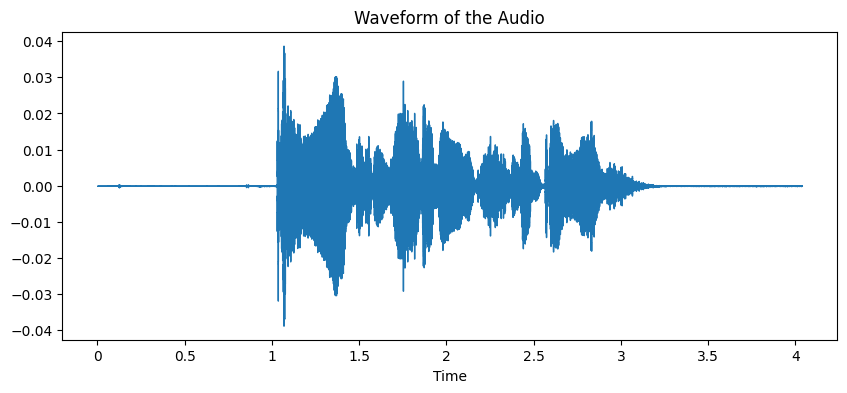

In [45]:
import matplotlib.pyplot as plt

def plot_waveform(file_path):
    X, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(X, sr=sample_rate)
    plt.title('Waveform of the Audio')
    plt.show()

plot_waveform(new_audio_file_path)